# Coffea Processors
This is a rendered copy of [processor.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/processor.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fprocessor.ipynb)

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * A [NanoEvents](https://coffeateam.github.io/coffea/notebooks/nanoevents.html) interface to the arrays being read from the TTree as inputs;
 * A generic `accumulate()` utility to reduce the outputs to a single result, as showin in the accumulators notebook tutorial; and
 * A set of parallel executors to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), [WorkQueue](https://cctools.readthedocs.io/en/latest/work_queue/), and others.

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [Candidate](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for muons, since we will read it with `BaseSchema` interpretation (the files used here could be read with `NanoAODSchema` but we want to show how to build vector objects from other TTree formats) 
 * Calculating the dimuon invariant mass

In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda

from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)


class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        h_mass = (
            hda.Hist.new
            .StrCat(["opposite", "same"], name="sign")
            .Log(1000, 0.2, 200., name="mass", label="$m_{\mu\mu}$ [GeV]")
            .Int64()
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="opposite", mass=dimuon.mass)

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) != 0)
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        h_mass.fill(sign="same", mass=dimuon.mass)

        return {
            dataset: {
                "entries": ak.num(events, axis=0),
                "mass": h_mass,
            }
        }

    def postprocess(self, accumulator):
        pass

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of `uproot.lazy`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [2]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema

filename = "file://Run2012B_DoubleMuParked.root"
events = NanoEventsFactory.from_root(
    {filename: "Events"},
    entry_stop=10000,
    metadata={"dataset": "DoubleMuon"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
computed, = dask.compute(out)
print(computed)

{'DoubleMuon': {'entries': 26084708, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 12819617.0 (12835141.0 with flow)}}


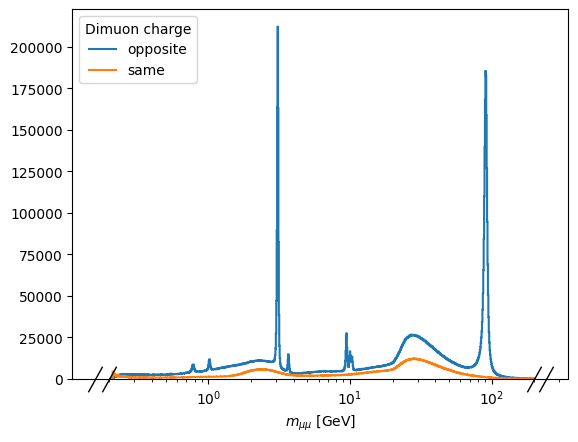

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
computed["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

One could expand on this code to run over several chunks of the file, setting `entry_start` and `entry_stop` as appropriate. Then, several datasets could be processed by iterating over several files. However, the `dask.compute` and `coffea.dataset_tools` can help with this! We can `preprocess` multiple files and then use our custom `MyProcessor` class to generate the relevant dask task graph. Finally, the result can be obtained by calling `dask.compute`. Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [4]:
fileset = {
    'DoubleMuon': {
        "files": {
            'file://Run2012B_DoubleMuParked.root': "Events",
            'file://Run2012C_DoubleMuParked.root': "Events",
        }
    },
    'ZZ to 4mu': {
        "files": {
            'file://ZZTo4mu.root': "Events"
        }
    }
}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    align_clusters=False,
    files_per_batch=100,
    skip_bad_files=True,
    save_form=False,
)

In [5]:
to_compute = apply_to_fileset(
                MyProcessor(),
                max_chunks(dataset_runnable, 1000),
                schemaclass=BaseSchema,
            )
out = dask.compute(to_compute)[0]
print(out)

{'DoubleMuon': {'DoubleMuon': {'entries': 61540413, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 31069275.0 (31104343.0 with flow)}}, 'ZZ to 4mu': {'ZZ to 4mu': {'entries': 1499064, 'mass': Hist(
  StrCategory(['opposite', 'same'], name='sign'),
  Regular(1000, 0.2, 200, transform=log, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Int64()) # Sum: 288709.0 (289326.0 with flow)}}}


The run may depend on how many cores are available on the machine you are running this notebook and your connection to `eospublic.cern.ch`.

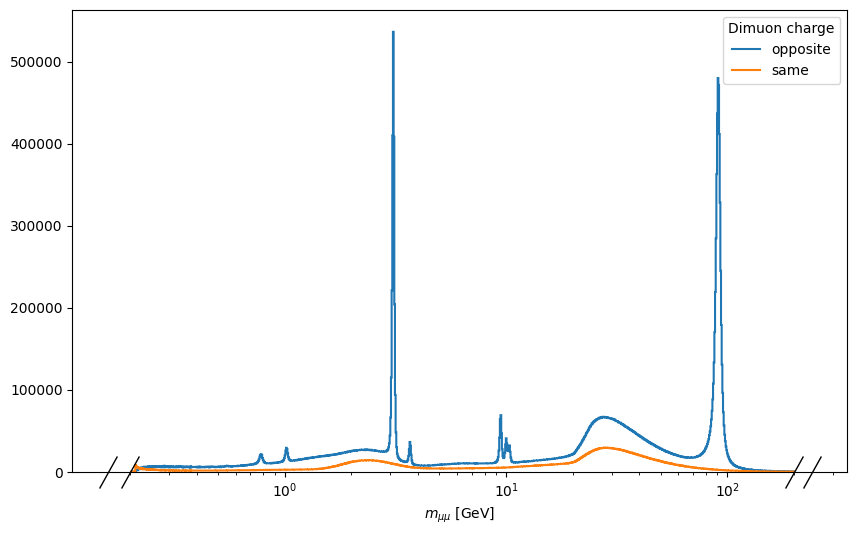

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
out["DoubleMuon"]["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")
ax.legend(title="Dimuon charge")

## Getting fancy
Let's flesh out this analysis into a 4-muon analysis, searching for diboson events:

In [7]:
from collections import defaultdict
import numba


@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}
    
    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


class FancyDimuonProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        mass_axis = hist.axis.Regular(300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]")
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")
        
        h_nMuons = hda.Hist(
            dataset_axis,
            hda.hist.hist.axis.IntCategory(range(6), name="nMuons", label="Number of good muons"),
            storage="weight", label="Counts",
        )
        h_m4mu = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ1 = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptZ1mu2 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
                
        cutflow = defaultdict(int)
        
        dataset = events.metadata['dataset']
        muons = ak.zip({
            "pt": events.Muon_pt,
            "eta": events.Muon_eta,
            "phi": events.Muon_phi,
            "mass": events.Muon_mass,
            "charge": events.Muon_charge,
            "isolation": events.Muon_pfRelIso03_all,
        }, with_name="PtEtaPhiMCandidate", behavior=candidate.behavior)
        
        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]
        
        cutflow['all events'] = ak.num(muons, axis=0)
        
        # impose some quality and minimum pt cuts on the muons
        muons = muons[
            (muons.pt > 5)
            & (muons.isolation < 0.2)
        ]
        cutflow['at least 4 good muons'] += ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))
        
        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]
        
        # find all candidates with helper function
        fourmuon = find_4lep(muons.compute(), ak.ArrayBuilder()).snapshot()
        if ak.all(ak.num(fourmuon) == 0):
            # skip processing as it is an EmptyArray
            return {
                'nMuons': h_nMuons,
                'cutflow': {dataset: cutflow},
            }

        fourmuon = [muons.compute()[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })
        
        cutflow['at least one candidate'] += ak.sum(ak.num(fourmuon) > 0)
         
        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.) & (fourmuon.z2.p4.mass > 20.)]
        cutflow['minimum dimuon mass'] += ak.sum(ak.num(fourmuon) > 0)
        
        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])
        
        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset, 
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset, 
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            'nMuons': h_nMuons,
            'mass': h_m4mu,
            'mass_z1': h_mZ1,
            'mass_z2': h_mZ2,
            'pt_z1_mu1': h_ptZ1mu1,
            'pt_z1_mu2': h_ptZ1mu2,
            'cutflow': {dataset: cutflow},
        }

    def postprocess(self, accumulator):
        pass

In [8]:
import time

tstart = time.time()

to_compute = apply_to_fileset(
                FancyDimuonProcessor(),
                max_chunks(dataset_runnable, 1000),
                schemaclass=BaseSchema,
            )
out = dask.compute(to_compute)[0]
print(out)

elapsed = time.time() - tstart

{'DoubleMuon': {'nMuons': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  IntCategory([0, 1, 2, 3, 4, 5], name='nMuons', label='Number of good muons'),
  storage=Weight()) # Sum: WeightedSum(value=6.13966e+07, variance=6.13966e+07) (WeightedSum(value=6.15404e+07, variance=6.15404e+07) with flow), 'mass': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=59932, variance=59932) (WeightedSum(value=67186, variance=67186) with flow), 'mass_z1': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=66708, variance=66708) (WeightedSum(value=67186, variance=67186) with flow), 'mass_z2': Hist(
  StrCategory(['DoubleMuon'], growth=True, name='dataset', la

In [9]:
nevt = out['ZZ to 4mu']['cutflow']['ZZ to 4mu']['all events'] + out['DoubleMuon']['cutflow']['DoubleMuon']['all events']
print("Events/s:", (nevt / elapsed).compute())

Events/s: 177327.66387518626


What follows is just us looking at the output, you can execute it if you wish

In [10]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = out['ZZ to 4mu']['cutflow']['ZZ to 4mu']['all events']

scaled = {}
for (name1, h1), (nam2, h2) in zip(out['ZZ to 4mu'].items(), out['DoubleMuon'].items()):
    if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
        scaled[name1] = h1.copy() + h2.copy()
        scaled[name1].view()[0, :] *= lumi * zzxs / nzz.compute()

(1, 60404452.32764899)

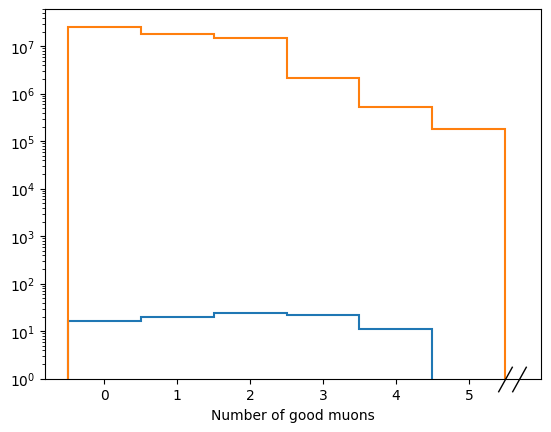

In [11]:
fig, ax = plt.subplots()
scaled['nMuons'].plot1d(ax=ax, overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(1, None)

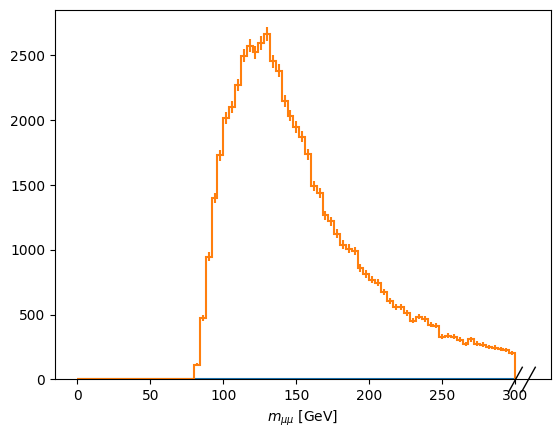

In [12]:
fig, ax = plt.subplots()

scaled['mass'][:, ::hist.rebin(4)].plot1d(ax=ax, overlay='dataset');

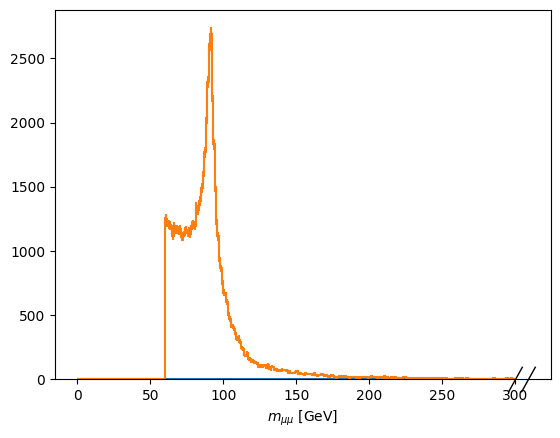

In [13]:
fig, ax = plt.subplots()

scaled['mass_z1'].plot1d(ax=ax, overlay='dataset');

(2.0, 300.0)

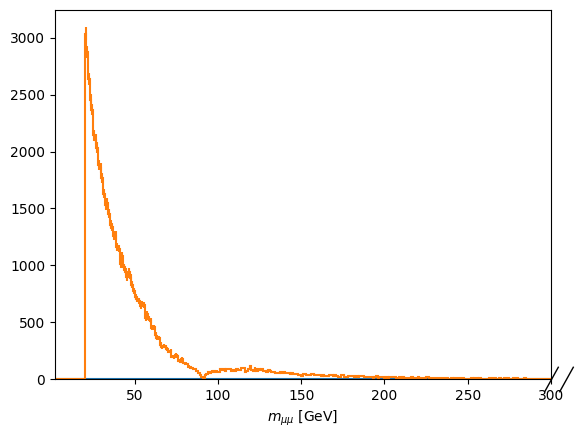

In [14]:
fig, ax = plt.subplots()

scaled['mass_z2'].plot1d(ax=ax, overlay='dataset')
ax.set_xlim(2, 300)
# ax.set_xscale('log')

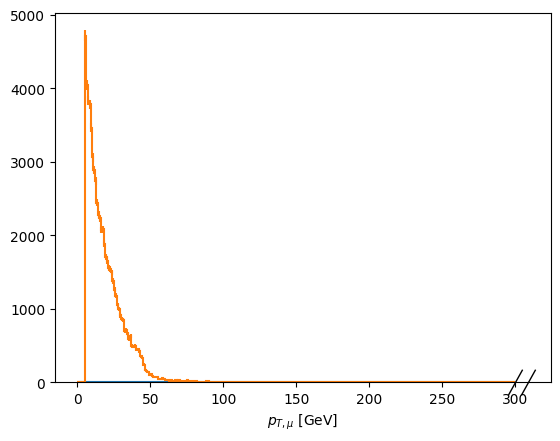

In [15]:
fig, ax = plt.subplots()

scaled['pt_z1_mu1'].plot1d(ax=ax, overlay='dataset');

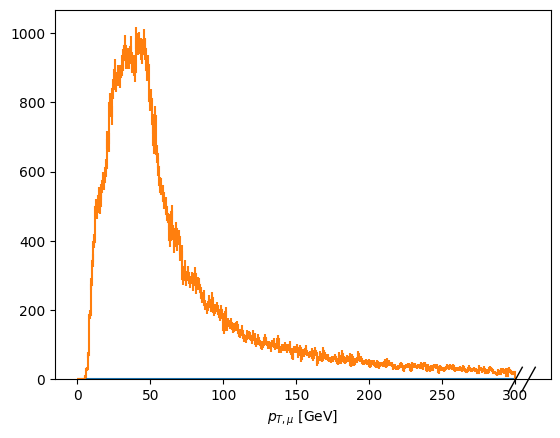

In [16]:
fig, ax = plt.subplots()

scaled['pt_z1_mu2'].plot1d(ax=ax, overlay='dataset');